In [13]:
#load_mat is used to load a matlab structure in python as a list of nested dictionaries. found with google 
import numpy as np
import scipy
from scipy.io import loadmat, matlab
import pandas as pd
import warnings
warnings.simplefilter('ignore')

def load_mat(filename):  
    def _check_vars(d):
        
    #checks if entries in dictionary are mat-objects. If yes
    #todict is called to change them to nested dictionaries
    
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _toarray(d[key])
        return d
    
    def _todict(matobj):
        
    #A recursive function which constructs from matobjects nested dictionaries
        
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d
    
    def _toarray(ndarray):
       
    ##A recursive function which constructs ndarray from cellarrays
    #(which are loaded as numpy ndarrays), recursing into the elements
    #if they contain matobjects.
       
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray
        
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)

In [15]:


struct_fname = 'all_rrs_agcorr1.mat'
mat = load_mat(struct_fname)
svc_data  = mat['svc_v3_2']

In [16]:
# Assuming svc_data is a structured numpy array or a list of dictionaries
rrs_3c_sv = np.array([
    entry['rrs_3C']  # Compute mean along axis 1
    for entry in svc_data if np.size(entry['ag_corr']) != 0
])

ag300_sv = np.array([
    entry['ag_corr']  # Extract 'ag_corr'
    for entry in svc_data if np.size(entry['ag_corr']) != 0
])

In [17]:
from scipy.optimize import curve_fit
import numpy as np

# Define the function
def func(x, S, alam):
    return alam * np.exp(-S * (x - 275))

# Define wavelength range
wl275 = np.linspace(275, 295, 21)

# Prepare output array for spectral slopes
s275 = np.empty(len(ag300_sv))  # Pre-allocate storage for slopes

# Extract spectral slopes
for i in range(ag300_sv.shape[0]):
    alam = ag300_sv[i, 35]  # Single value for alam
    ydata = ag300_sv[i, 35:56]  # Slice of ag300_sv for fitting
    
    # Perform curve fitting
    try:
        popt, _ = curve_fit(lambda x, S: func(x, S, alam), wl275, ydata)
        s275[i] = popt[0]  # Store fitted S value
    except RuntimeError:
        s275[i] = np.nan  # Handle failed fits

In [18]:

# Crop all rrs spectra astarting at 350 tos tart at 400

rrs_wl = svc_data[1]['rrs_wave']


olci_ind = np.where(np.isin(rrs_wl, [443,490,510,560,665]))
msi_ind = np.where(np.isin(rrs_wl, [443,490,560,665]))



In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Sample data
X_olci = np.log(rrs_3c_sv[:, olci_ind].squeeze())
X_msi = np.log(rrs_3c_sv[:, msi_ind].squeeze())
y_ag300 = np.log(ag300_sv[0:28, 61])  # Target (dependent variable) a300 = 61, a440 = 201
y_s275 = np.log(s275)

# Initialize the model
model = LinearRegression()

# Create a function to fit, predict, and extract coefficients and intercept
def fit_and_predict(X, y):
    model.fit(X, y)
    coefficients = model.coef_  # Get coefficients (slopes)
    intercept = model.intercept_  # Get intercept
    predictions = model.predict(X)  # Make predictions
    return coefficients, intercept, predictions

def reduced_major_axis_slope(X, y):
    """
    Calculate the slope of the Reduced Major Axis (RMA) regression line.
    
    Parameters:
        X (array-like): Independent variable data.
        y (array-like): Dependent variable data.
        
    Returns:
        slope (float): Slope of the RMA regression line.
    """
    # Calculate covariance and standard deviations
    cov_xy = np.cov(X, y, bias=True)[0, 1]  # Covariance between X and y
    std_x = np.std(X)  # Standard deviation of X
    std_y = np.std(y)  # Standard deviation of y
    
    # Calculate the RMA slope
    slope = np.sign(cov_xy) * (std_y / std_x)
    
    return slope

# Fit and predict for OLCI and MSI with ag300 and s275
olci_ag300_coef, olci_ag300_intercept, olci_ag300_pred = fit_and_predict(X_olci[0:28], y_ag300)
olci_s275_coef, olci_s275_intercept, olci_s275_pred = fit_and_predict(X_olci, y_s275)
msi_ag300_coef, msi_ag300_intercept, msi_ag300_pred = fit_and_predict(X_msi[0:28], y_ag300)
msi_s275_coef, msi_s275_intercept, msi_s275_pred = fit_and_predict(X_msi, y_s275)


olci_ag300_slope = reduced_major_axis_slope(ag300_sv[0:28,61],np.exp(olci_ag300_pred)[0:28])
olci_s275_slope = reduced_major_axis_slope(s275[0:28],np.exp(olci_s275_pred)[0:28])


msi_ag300_slope = reduced_major_axis_slope(ag300_sv[0:28,61],np.exp(msi_ag300_pred)[0:28])
msi_s275_slope = reduced_major_axis_slope(s275[0:28],np.exp(msi_s275_pred)[0:28])


In [20]:
def mean_absolute_error(x,y, n):
    mae = 10 ** (np.nansum(np.abs(np.log10(y) - np.log10(x)))/ n ) - 1
    return mae

def calc_bias(x,y, n):
    bias = 10 ** (np.nansum(np.log10(y) - np.log10(x))/ n ) - 1
    return bias

def root_mean_square_error(x,y, n):
    rmse = (np.nansum((y - x) ** 2 )/ n ) ** 0.5
    return rmse

def mean_absolute_percent_error(x,y):
    mape = np.nanmedian(np.abs(y - x) / x) * 100
    return mape


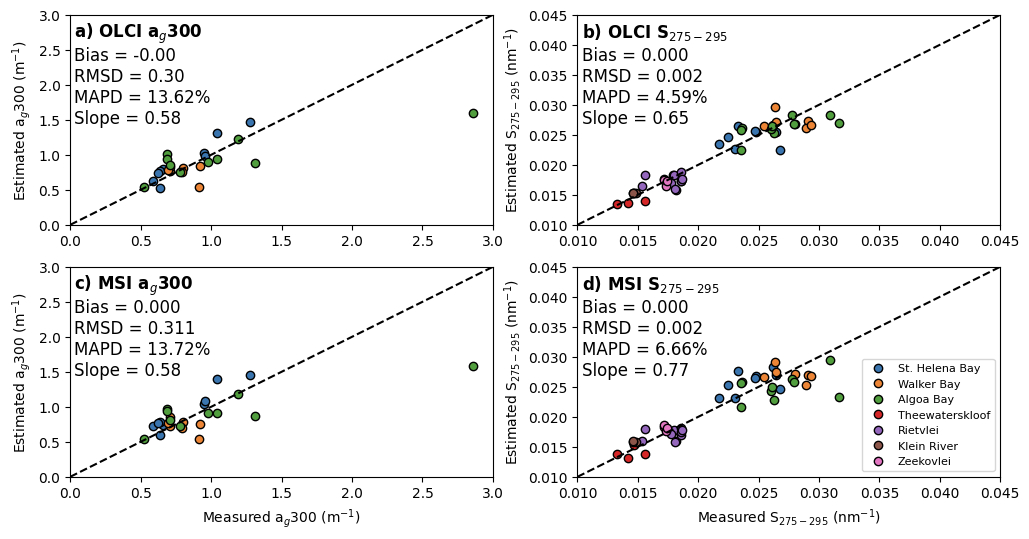

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (12,6))

fls = 12

n  =61
ax[0,0].plot(ag300_sv[11:20,n],np.exp(olci_ag300_pred)[11:20],'o', markerfacecolor = '#3B75AF',markeredgecolor = 'k',label = 'St. Helena Bay')
ax[0,0].plot(ag300_sv[21:28,n],np.exp(olci_ag300_pred)[21:28],'o', markerfacecolor = '#ED8536',markeredgecolor = 'k',label = 'Walker Bay')
ax[0,0].plot(ag300_sv[0:10,n],np.exp(olci_ag300_pred)[0:10],'o', markerfacecolor = '#519E3E',markeredgecolor = 'k',label = 'Algoa Bay')
ax[0,0].axline([0,0], xy2=None, slope=1,color = 'black',linestyle = '--')
ax[0,0].set_ylabel('Estimated a$_{g}$300 (m$^{-1}$)')
ax[0,0].set_xlim([0,3])
ax[0,0].set_ylim([0,3])


mae = mean_absolute_error(ag300_sv[0:28,n],np.exp(olci_ag300_pred), np.size(ag300_sv[0:28,n]))
bias = calc_bias(ag300_sv[0:28,n],np.exp(olci_ag300_pred), np.size(ag300_sv[0:28,n]))
rmse = root_mean_square_error(ag300_sv[0:28,n],np.exp(olci_ag300_pred), np.size(ag300_sv[0:28,n]))
mape = mean_absolute_percent_error(ag300_sv[0:28,n],np.exp(olci_ag300_pred))

ax[0,0].text(0.01, 0.97, 'a) OLCI a$_{g}$300', transform=ax[0,0].transAxes, 
               ha='left', va='top', fontsize=fls, fontweight='bold',color = 'k')



#ax[0,0].text(0.01, 0.85, 'MAE = ' + str(format(mae, '.2f')), transform=ax[0,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,0].text(0.01, 0.85, 'Bias = ' + str(format(bias, '.2f')), transform=ax[0,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,0].text(0.01, 0.75, 'RMSD = ' + str(format(rmse, '.2f')), transform=ax[0,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,0].text(0.01, 0.65, 'MAPD = ' + str(format(mape, '.2f'))+'%', transform=ax[0,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,0].text(0.01, 0.55, 'Slope = ' + str(format(olci_ag300_slope, '.2f')), transform=ax[0,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')




ax[0,1].plot(s275[11:20],np.exp(olci_s275_pred)[11:20],'o', markerfacecolor = '#3B75AF',markeredgecolor = 'k',label = 'St. Helena Bay')
ax[0,1].plot(s275[21:28],np.exp(olci_s275_pred)[21:28],'o', markerfacecolor = '#ED8536',markeredgecolor = 'k',label = 'Walker Bay')
ax[0,1].plot(s275[0:10],np.exp(olci_s275_pred)[0:10],'o', markerfacecolor = '#519E3E',markeredgecolor = 'k',label = 'Algoa Bay')


ax[0,1].plot(s275[50:54],np.exp(olci_s275_pred)[50:54],'o', markerfacecolor = '#d62728',markeredgecolor = 'k',label = 'Theewaterskloof')
ax[0,1].plot(s275[38:49],np.exp(olci_s275_pred)[38:49],'o', markerfacecolor = '#9467bd',markeredgecolor = 'k',label = 'Rietvlei')
ax[0,1].plot(s275[34:37],np.exp(olci_s275_pred)[34:37],'o', markerfacecolor = '#8c564b',markeredgecolor = 'k',label = 'Klein River')
ax[0,1].plot(s275[29:33],np.exp(olci_s275_pred)[29:33],'o', markerfacecolor = '#e377c2',markeredgecolor = 'k',label = 'Zeekovlei')


ax[0,1].axline([0,0], xy2=None, slope=1,color = 'black',linestyle = '--')
ax[0,1].set_ylabel('Estimated S$_{275-295}$ (nm$^{-1}$)')
ax[0,1].set_xlim([0.01,0.045])
ax[0,1].set_ylim([0.01,0.045])


mae = mean_absolute_error(s275,np.exp(olci_s275_pred), np.size(s275))
bias = calc_bias(s275,np.exp(olci_s275_pred), np.size(s275))
rmse = root_mean_square_error(s275,np.exp(olci_s275_pred), np.size(s275))
mape = mean_absolute_percent_error(s275,np.exp(olci_s275_pred))

ax[0,1].text(0.01, 0.97, 'b) OLCI S$_{275-295}$', transform=ax[0,1].transAxes, 
               ha='left', va='top', fontsize=fls, fontweight='bold',color = 'k')
#ax[0,1].text(0.01, 0.85, 'MAE = ' + str(format(mae, '.2f')), transform=ax[0,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,1].text(0.01, 0.85, 'Bias = ' + str(format(bias, '.3f')), transform=ax[0,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,1].text(0.01, 0.75, 'RMSD = ' + str(format(rmse, '.3f')), transform=ax[0,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,1].text(0.01, 0.65, 'MAPD = ' + str(format(mape, '.2f'))+'%', transform=ax[0,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[0,1].text(0.01, 0.55, 'Slope = ' + str(format(olci_s275_slope, '.2f')), transform=ax[0,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')




ax[1,0].plot(ag300_sv[11:20,n],np.exp(msi_ag300_pred)[11:20],'o', markerfacecolor = '#3B75AF',markeredgecolor = 'k',label = 'St. Helena Bay')
ax[1,0].plot(ag300_sv[21:28,n],np.exp(msi_ag300_pred)[21:28],'o', markerfacecolor = '#ED8536',markeredgecolor = 'k',label = 'Walker Bay')
ax[1,0].plot(ag300_sv[0:10,n],np.exp(msi_ag300_pred)[0:10],'o', markerfacecolor = '#519E3E',markeredgecolor = 'k',label = 'Algoa Bay')


ax[1,0].axline([0,0], xy2=None, slope=1,color = 'black',linestyle = '--')
ax[1,0].set_ylabel('Estimated a$_{g}$300 (m$^{-1}$)')
ax[1,0].set_xlabel('Measured a$_{g}$300 (m$^{-1}$)')
ax[1,0].set_xlim([0,3])
ax[1,0].set_ylim([0,3])


mae = mean_absolute_error(ag300_sv[0:28,n],np.exp(msi_ag300_pred), np.size(ag300_sv[0:28,n]))
bias = calc_bias(ag300_sv[0:28,n],np.exp(msi_ag300_pred), np.size(ag300_sv[0:28,n]))
rmse = root_mean_square_error(ag300_sv[0:28,n],np.exp(msi_ag300_pred), np.size(ag300_sv[0:28,n]))
mape = mean_absolute_percent_error(ag300_sv[0:28,n],np.exp(msi_ag300_pred))


ax[1,0].text(0.01, 0.97, 'c) MSI a$_{g}$300', transform=ax[1,0].transAxes, 
               ha='left', va='top', fontsize=fls, fontweight='bold',color = 'k')

#ax[1,0].text(0.01, 0.85, 'MAE = ' + str(format(mae, '.2f')), transform=ax[1,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,0].text(0.01, 0.85, 'Bias = ' + str(format(bias, '.3f')), transform=ax[1,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,0].text(0.01, 0.75, 'RMSD = ' + str(format(rmse, '.3f')), transform=ax[1,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,0].text(0.01, 0.65, 'MAPD = ' + str(format(mape, '.2f')) +'%', transform=ax[1,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,0].text(0.01, 0.55, 'Slope = ' + str(format(msi_ag300_slope, '.2f')), transform=ax[1,0].transAxes, ha='left', va='top', fontsize=fls,color = 'k')




ax[1,1].plot(s275[11:20],np.exp(msi_s275_pred)[11:20],'o', markerfacecolor = '#3B75AF',markeredgecolor = 'k',label = 'St. Helena Bay')
ax[1,1].plot(s275[21:28],np.exp(msi_s275_pred)[21:28],'o', markerfacecolor = '#ED8536',markeredgecolor = 'k',label = 'Walker Bay')
ax[1,1].plot(s275[0:10],np.exp(msi_s275_pred)[0:10],'o', markerfacecolor = '#519E3E',markeredgecolor = 'k',label = 'Algoa Bay')
ax[1,1].plot(s275[50:54],np.exp(msi_s275_pred)[50:54],'o', markerfacecolor = '#d62728',markeredgecolor = 'k',label = 'Theewaterskloof')
ax[1,1].plot(s275[38:49],np.exp(msi_s275_pred)[38:49],'o', markerfacecolor = '#9467bd',markeredgecolor = 'k',label = 'Rietvlei')
ax[1,1].plot(s275[34:37],np.exp(msi_s275_pred)[34:37],'o', markerfacecolor = '#8c564b',markeredgecolor = 'k',label = 'Klein River')
ax[1,1].plot(s275[29:33],np.exp(msi_s275_pred)[29:33],'o', markerfacecolor = '#e377c2',markeredgecolor = 'k',label = 'Zeekovlei')




ax[1,1].legend( loc='lower right', fontsize = "8")


ax[1,1].set_xlim([0.01,0.045])
ax[1,1].set_ylim([0.01,0.045])

ax[1,1].axline([0,0], xy2=None, slope=1,color = 'black',linestyle = '--')
ax[1,1].set_ylabel('Estimated S$_{275-295}$ (nm$^{-1}$)')
ax[1,1].set_xlabel('Measured S$_{275-295}$ (nm$^{-1}$)')


mae = mean_absolute_error(s275,np.exp(msi_s275_pred), np.size(s275))
bias = calc_bias(s275,np.exp(msi_s275_pred), np.size(s275))
rmse = root_mean_square_error(s275,np.exp(msi_s275_pred), np.size(s275))
mape = mean_absolute_percent_error(s275,np.exp(msi_s275_pred))


ax[1,1].text(0.01, 0.97, 'd) MSI S$_{275-295}$', transform=ax[1,1].transAxes, 
               ha='left', va='top', fontsize=fls, fontweight='bold',color = 'k')

#ax[1,1].text(0.01, 0.85, 'MAE = ' + str(format(mae, '.2f')), transform=ax[1,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,1].text(0.01, 0.85, 'Bias = ' + str(format(bias, '.3f')), transform=ax[1,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,1].text(0.01, 0.75, 'RMSD = ' + str(format(rmse, '.3f')), transform=ax[1,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,1].text(0.01, 0.65, 'MAPD = ' + str(format(mape, '.2f')) + '%', transform=ax[1,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')
ax[1,1].text(0.01, 0.55, 'Slope = ' + str(format(msi_s275_slope, '.2f')), transform=ax[1,1].transAxes, ha='left', va='top', fontsize=fls,color = 'k')

plt.show()

